In [1]:
from astropy.table import Table, join,unique,vstack
import numpy as np
import fitsio
from matplotlib import pyplot as plt
import sys, os
from scipy.signal import medfilt
from scipy import stats
from scipy.stats import moment
from astropy.table import Table, join
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

import matplotlib as mpl
mpl.rc('xtick', labelsize=14) 
mpl.rc('ytick', labelsize=14) 
mpl.rc('axes', titlesize=14)
mpl.rc('axes', labelsize=15)  
mpl.rc('legend', fontsize=13)  

Defining path for particular coadd for BGS targets. All tiles in SV0 and miniSV2 commissioning are located at: '/global/cfs/cdirs/desi/spectro/redux/daily/tiles/'

**For SV0 the BGS targets are the tiles:** 66000 (20200314), 66014 (20200314), 66003 (20200315)

**For miniSV2 the BGS targets are the tiles:** 70500 (20200228, 20200328), 70502 (20200225, 20200227), 70510 (20200229, 20200304)

In [2]:
coaddir = '/global/cfs/cdirs/desi/spectro/redux/daily/tiles/'

Now for a particular tile/night we construct the complete target file

In [3]:
tile = 66000
night = '20200314'

In [4]:
#put data from different spectrographs together, one table for fibermap, other for z
specs = []
#find out which spectrograph have data
for si in range(0,10):
    try:
        fitsio.read(coaddir+str(tile)+'/'+night+'/zbest-'+str(si)+'-'+str(tile)+'-'+night+'.fits')
        specs.append(si)
    except:
        print('no spectrograph '+str(si)+ ' on night '+night)
print('spectrographs with data:')
print(specs)

spectrographs with data:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [5]:
wavelenght = fitsio.read(coaddir+str(tile)+'/'+night+'/coadd-'+str(specs[0])+'-'+str(tile)+'-'+night+'.fits',ext=2)
print("index range in blue band: ",np.where(wavelenght[wavelenght<4000])[0][-1], np.where(wavelenght[wavelenght<5800])[0][-1])
print("index range in red band: ",np.where(wavelenght[wavelenght<5800])[0][-1], np.where(wavelenght[wavelenght<7600])[0][-1])
print("index range in z band: ",np.where(wavelenght[wavelenght<7600])[0][-1], np.where(wavelenght[wavelenght<9800])[0][-1])
indexes=[np.where(wavelenght[wavelenght<4000])[0][-1], np.where(wavelenght[wavelenght<5800])[0][-1],
         np.where(wavelenght[wavelenght<7600])[0][-1], np.where(wavelenght[wavelenght<9800])[0][-1]]
print("Cuts for bands",indexes)

index range in blue band:  500 2750
index range in red band:  2750 4999
index range in z band:  4999 7749
Cuts for bands [500, 2750, 4999, 7749]


In [6]:
def snr_band_mea(data):
    #data=medfilt(data,99)
    mean_b=np.mean(data[indexes[0]:indexes[1]])
    sigma_b=np.std(data[indexes[0]:indexes[1]],ddof=1)
    snr_b=np.abs(mean_b/sigma_b)#np.where(sigma_b==0,0,mean_b/sigma_b)
    mean_r=np.mean(data[indexes[1]:indexes[2]])
    sigma_r=np.std(data[indexes[1]:indexes[2]],ddof=1)
    snr_r=np.abs(mean_r/sigma_r)#np.where(sigma_r==0,0,mean_r/sigma_r)
    mean_z=np.mean(data[indexes[2]:indexes[3]])
    sigma_z=np.std(data[indexes[2]:indexes[3]],ddof=1)
    snr_z=np.abs(mean_z/sigma_z)#np.where(sigma_z==0,0,mean_z/sigma_z)
    return mean_b,mean_r,mean_z,sigma_b,sigma_r,sigma_z,snr_b,snr_r,snr_z
def moment_band(data,k):
    moment_b=moment(data[indexes[0]:indexes[1]], moment=k)/np.std(data[indexes[0]:indexes[1]],ddof=1)
    moment_r=moment(data[indexes[1]:indexes[2]], moment=k)/np.std(data[indexes[1]:indexes[2]],ddof=1)
    moment_z=moment(data[indexes[2]:indexes[3]], moment=k)/np.std(data[indexes[2]:indexes[3]],ddof=1)
    return moment_b, moment_r, moment_z

In [7]:
z,dchi2,specie=[],[],[]
flux_r,flux_g,flux_z,fiberflux_r,fiberflux_g,fiberflux_z=[],[],[],[],[],[]
snr_b,snr_r,snr_z=[],[],[]
m2_b,m2_r,m2_z=[],[],[]
for i in range(0,len(specs)):
    zspec1 = fitsio.read(coaddir+str(tile)+'/'+night+'/zbest-'+str(specs[i])+'-'+str(tile)+'-'+night+'.fits',ext=1)
    zspec2 = fitsio.read(coaddir+str(tile)+'/'+night+'/zbest-'+str(specs[i])+'-'+str(tile)+'-'+night+'.fits',ext=2)
    cspec2 = fitsio.read(coaddir+str(tile)+'/'+night+'/coadd-'+str(specs[i])+'-'+str(tile)+'-'+night+'.fits',ext=2)
    cspec3 = fitsio.read(coaddir+str(tile)+'/'+night+'/coadd-'+str(specs[i])+'-'+str(tile)+'-'+night+'.fits',ext=3)
    for j in range(len(zspec1)):
        z.append(zspec1[j]["Z"])
        dchi2.append(zspec1[j]["DELTACHI2"])
        specie.append(zspec1[j]["SPECTYPE"])
        flux_r.append(zspec2[j]["FLUX_R"])
        flux_g.append(zspec2[j]["FLUX_G"])
        flux_z.append(zspec2[j]["FLUX_Z"])
        fiberflux_r.append(zspec2[j]["FIBERFLUX_R"])
        fiberflux_g.append(zspec2[j]["FIBERFLUX_G"])
        fiberflux_z.append(zspec2[j]["FIBERFLUX_Z"])
        snr_b.append(snr_band_mea(cspec3[j])[6])
        snr_r.append(snr_band_mea(cspec3[j])[7])
        snr_z.append(snr_band_mea(cspec3[j])[8])
        m2_b.append(moment_band(cspec3[j],2)[0])
        m2_r.append(moment_band(cspec3[j],2)[1])
        m2_z.append(moment_band(cspec3[j],2)[2])
z,dchi2,specie=np.array(z),np.array(dchi2),np.array(specie)
flux_r,flux_g,flux_z=np.array(flux_r),np.array(flux_g),np.array(flux_z)
fiberflux_r,fiberflux_g,fiberflux_z=np.array(fiberflux_r),np.array(fiberflux_g),np.array(fiberflux_z)
snr_b,snr_r,snr_z=np.array(snr_b),np.array(snr_r),np.array(snr_z)
m2_b,m2_r,m2_z=np.array(m2_b),np.array(m2_r),np.array(m2_z)

In [8]:
table66000=Table([z,dchi2,specie,flux_r,flux_g,flux_z,fiberflux_r,fiberflux_g,fiberflux_z,snr_b,snr_r,snr_z,m2_b,m2_r,m2_z],
            names=['z','dchi2','specie','flux_r','flux_g','flux_z','fiberflux_r','fiberflux_g','fiberflux_z','snr_b','snr_r','snr_z','m2_b','m2_r','m2_z'])

In [9]:
#table

In [10]:
isgal=table66000["specie"]=='GALAXY'
isstar=table66000["specie"]=='STAR'
isqso=table66000["specie"]=='QSO'

Put all in a function..

In [11]:
def make_data(tile,night):
    #put data from different spectrographs together, one table for fibermap, other for z
    specs = []
    #find out which spectrograph have data
    for si in range(0,10):
        try:
            fitsio.read(coaddir+str(tile)+'/'+str(night)+'/zbest-'+str(si)+'-'+str(tile)+'-'+str(night)+'.fits')
            specs.append(si)
        except:
            print('no spectrograph '+str(si)+ ' on tile+night '+str(tile)+'/'+str(night))
    print('spectrographs with data on tile+night '+str(tile)+'/'+str(night))
    print(specs)
    
    wavelenght = fitsio.read(coaddir+str(tile)+'/'+night+'/coadd-'+str(specs[0])+'-'+str(tile)+'-'+str(night)+'.fits',ext=2)
    #print("index range in blue band: ",np.where(wavelenght[wavelenght<4000])[0][-1], np.where(wavelenght[wavelenght<5800])[0][-1])
    #print("index range in red band: ",np.where(wavelenght[wavelenght<5800])[0][-1], np.where(wavelenght[wavelenght<7600])[0][-1])
    #print("index range in z band: ",np.where(wavelenght[wavelenght<7600])[0][-1], np.where(wavelenght[wavelenght<9800])[0][-1])
    indexes=[np.where(wavelenght[wavelenght<4000])[0][-1], np.where(wavelenght[wavelenght<5800])[0][-1],
         np.where(wavelenght[wavelenght<7600])[0][-1], np.where(wavelenght[wavelenght<9800])[0][-1]]
    
    z,dchi2,specie=[],[],[]
    flux_r,flux_g,flux_z,fiberflux_r,fiberflux_g,fiberflux_z=[],[],[],[],[],[]
    snr_b,snr_r,snr_z=[],[],[]
    m2_b,m2_r,m2_z=[],[],[]
    for i in range(0,len(specs)):
        zspec1 = fitsio.read(coaddir+str(tile)+'/'+night+'/zbest-'+str(specs[i])+'-'+str(tile)+'-'+str(night)+'.fits',ext=1)
        zspec2 = fitsio.read(coaddir+str(tile)+'/'+night+'/zbest-'+str(specs[i])+'-'+str(tile)+'-'+str(night)+'.fits',ext=2)
        cspec2 = fitsio.read(coaddir+str(tile)+'/'+night+'/coadd-'+str(specs[i])+'-'+str(tile)+'-'+str(night)+'.fits',ext=2)
        cspec3 = fitsio.read(coaddir+str(tile)+'/'+night+'/coadd-'+str(specs[i])+'-'+str(tile)+'-'+str(night)+'.fits',ext=3)
        for j in range(len(zspec1)):
            z.append(zspec1[j]["Z"])
            dchi2.append(zspec1[j]["DELTACHI2"])
            specie.append(zspec1[j]["SPECTYPE"])
            flux_r.append(zspec2[j]["FLUX_R"])
            flux_g.append(zspec2[j]["FLUX_G"])
            flux_z.append(zspec2[j]["FLUX_Z"])
            fiberflux_r.append(zspec2[j]["FIBERFLUX_R"])
            fiberflux_g.append(zspec2[j]["FIBERFLUX_G"])
            fiberflux_z.append(zspec2[j]["FIBERFLUX_Z"])
            snr_b.append(snr_band_mea(cspec3[j])[6])
            snr_r.append(snr_band_mea(cspec3[j])[7])
            snr_z.append(snr_band_mea(cspec3[j])[8])
            m2_b.append(moment_band(cspec3[j],2)[0])
            m2_r.append(moment_band(cspec3[j],2)[1])
            m2_z.append(moment_band(cspec3[j],2)[2])
    z,dchi2,specie=np.array(z),np.array(dchi2),np.array(specie)
    flux_r,flux_g,flux_z=np.array(flux_r),np.array(flux_g),np.array(flux_z)
    fiberflux_r,fiberflux_g,fiberflux_z=np.array(fiberflux_r),np.array(fiberflux_g),np.array(fiberflux_z)
    snr_b,snr_r,snr_z=np.array(snr_b),np.array(snr_r),np.array(snr_z)
    m2_b,m2_r,m2_z=np.array(m2_b),np.array(m2_r),np.array(m2_z)
    
    table=Table([z,dchi2,specie,flux_r,flux_g,flux_z,fiberflux_r,fiberflux_g,fiberflux_z,snr_b,snr_r,snr_z,m2_b,m2_r,m2_z],
            names=['z','dchi2','specie','flux_r','flux_g','flux_z','fiberflux_r','fiberflux_g','fiberflux_z','snr_b','snr_r','snr_z','m2_b','m2_r','m2_z'])
    table['rmag']=22.5-2.5*np.log10(table['flux_r'])
    table['gmag']=22.5-2.5*np.log10(table['flux_g'])
    table['zmag']=22.5-2.5*np.log10(table['flux_z'])
    return table

In [12]:
rho, pval = stats.spearmanr(table66000["snr_z"], np.log10(table66000["dchi2"]), nan_policy='omit')
print("Correlation coeficient= ",rho)
print("p-value= ", pval)

Correlation coeficient=  0.7579833593757523
p-value=  0.0


In [13]:
data_66000_1=make_data(66000,'20200314')
data_66003_1=make_data(66003,'20200315')
data_66014_1=make_data(66014,'20200314')
data_66019_1=make_data(66019,'20200314')

#data_70500_1=make_data(70500,'20200228')
data_70500_2=make_data(70500,'20200303')
data_70502_1=make_data(70502,'20200225')
#data_70502_2=make_data(70502,'20200227')
#data_70510_1=make_data(70510,'20200229')
data_70510_2=make_data(70510,'20200304')

spectrographs with data on tile+night 66000/20200314
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
spectrographs with data on tile+night 66003/20200315
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
spectrographs with data on tile+night 66014/20200314
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
spectrographs with data on tile+night 66019/20200314
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
no spectrograph 1 on tile+night 70500/20200303
no spectrograph 2 on tile+night 70500/20200303
no spectrograph 4 on tile+night 70500/20200303
no spectrograph 5 on tile+night 70500/20200303
no spectrograph 8 on tile+night 70500/20200303
spectrographs with data on tile+night 70500/20200303
[0, 3, 6, 7, 9]
no spectrograph 1 on tile+night 70502/20200225
no spectrograph 2 on tile+night 70502/20200225
no spectrograph 4 on tile+night 70502/20200225
no spectrograph 5 on tile+night 70502/20200225
no spectrograph 8 on tile+night 70502/20200225
spectrographs with data on tile+night 70502/20200225
[0, 3, 6, 7, 9]
no spectrograph 1 on tile+night 70510/20200304
no spectr

In [14]:
dataSV0=np.hstack((data_66000_1,data_66003_1,data_66014_1,data_66019_1))
dataSV2=np.hstack((data_70500_2,data_70502_1,data_70510_2))
data_full=np.hstack((dataSV0,dataSV2))

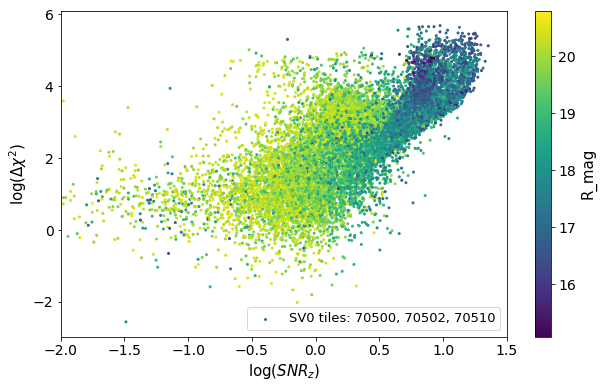

In [15]:
plt.figure(figsize=(10,6))
plt.scatter(np.log10(dataSV0["snr_z"]),np.log10(dataSV0["dchi2"]),s=4,c=dataSV0["rmag"],label='SV0 tiles: 70500, 70502, 70510')
cbar=plt.colorbar()
cbar.set_label('R_mag', rotation=90)
plt.ylabel("$\log(\Delta\chi^2)$")
plt.xlabel("$\log(SNR_z)$")
plt.xlim(-2,1.5)
plt.legend()
plt.show()

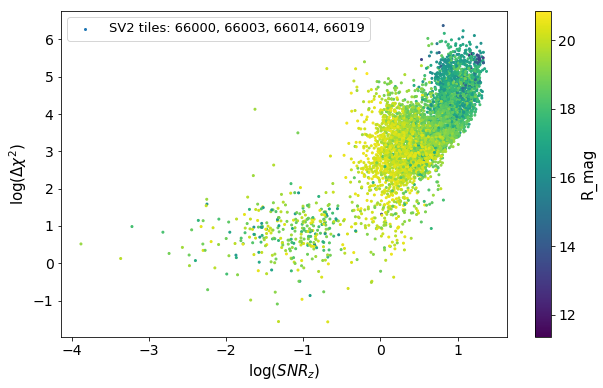

In [16]:
plt.figure(figsize=(10,6))
plt.scatter(np.log10(dataSV2["snr_z"]),np.log10(dataSV2["dchi2"]),s=4,c=dataSV2["rmag"],label='SV2 tiles: 66000, 66003, 66014, 66019')
cbar=plt.colorbar()
cbar.set_label('R_mag', rotation=90)
plt.ylabel("$\log(\Delta\chi^2)$")
plt.xlabel("$\log(SNR_z)$")
#plt.xlim(-2,1.5)
plt.legend()
plt.show()

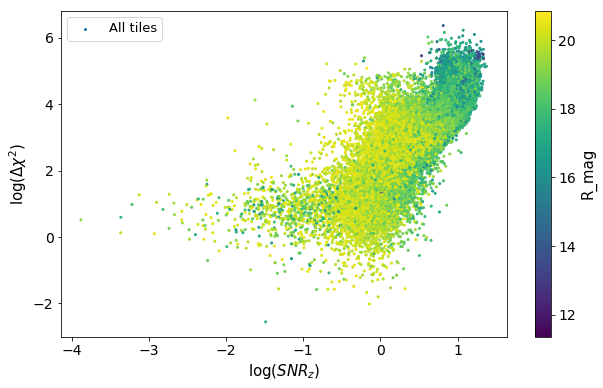

In [17]:
plt.figure(figsize=(10,6))
plt.scatter(np.log10(data_full["snr_z"]),np.log10(data_full["dchi2"]),s=4,c=data_full["rmag"],label='All tiles')
cbar=plt.colorbar()
cbar.set_label('R_mag', rotation=90)
plt.ylabel("$\log(\Delta\chi^2)$")
plt.xlabel("$\log(SNR_z)$")
#plt.xlim(-2,1.5)
plt.legend()
plt.show()

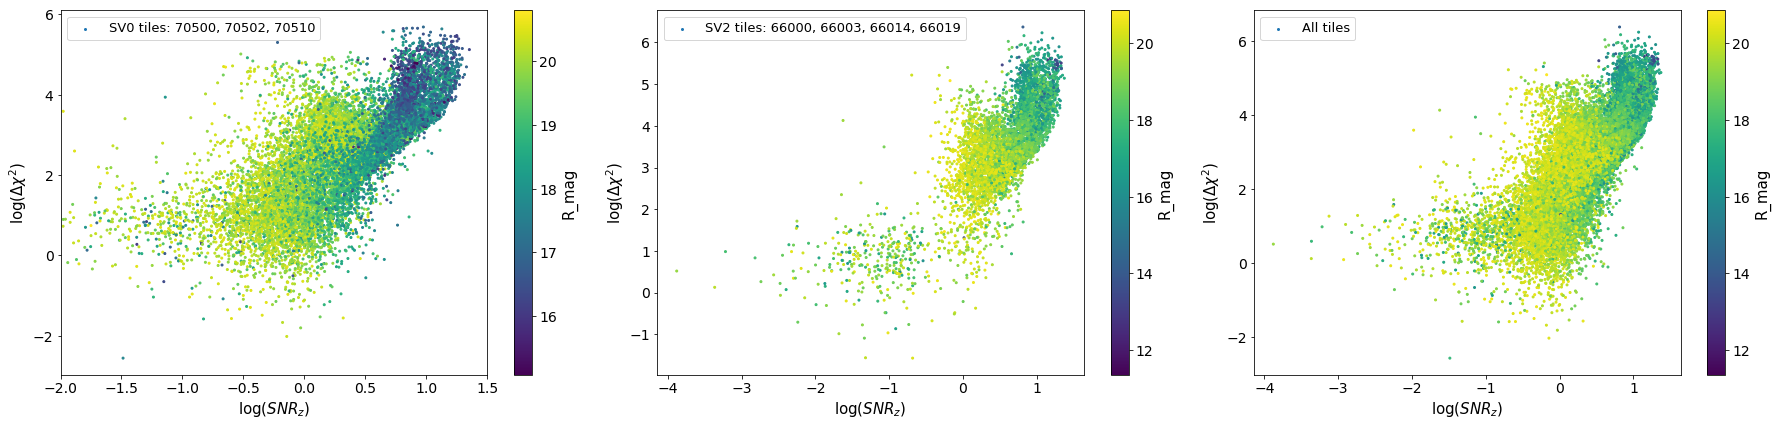

In [18]:
plt.figure(figsize=(25,6))
plt.subplot(1,3,1)
plt.scatter(np.log10(dataSV0["snr_z"]),np.log10(dataSV0["dchi2"]),s=4,c=dataSV0["rmag"],label='SV0 tiles: 70500, 70502, 70510')
cbar=plt.colorbar()
cbar.set_label('R_mag', rotation=90)
plt.ylabel("$\log(\Delta\chi^2)$")
plt.xlabel("$\log(SNR_z)$")
plt.xlim(-2,1.5)
plt.legend()
plt.subplot(1,3,2)
plt.scatter(np.log10(dataSV2["snr_z"]),np.log10(dataSV2["dchi2"]),s=4,c=dataSV2["rmag"],label='SV2 tiles: 66000, 66003, 66014, 66019')
cbar=plt.colorbar()
cbar.set_label('R_mag', rotation=90)
plt.ylabel("$\log(\Delta\chi^2)$")
plt.xlabel("$\log(SNR_z)$")
#plt.xlim(-2,1.5)
plt.legend()
plt.subplot(1,3,3)
plt.scatter(np.log10(data_full["snr_z"]),np.log10(data_full["dchi2"]),s=4,c=data_full["rmag"],label='All tiles')
cbar=plt.colorbar()
cbar.set_label('R_mag', rotation=90)
plt.ylabel("$\log(\Delta\chi^2)$")
plt.xlabel("$\log(SNR_z)$")
#plt.xlim(-2,1.5)
plt.legend()
plt.tight_layout(pad=1.0)
plt.show()

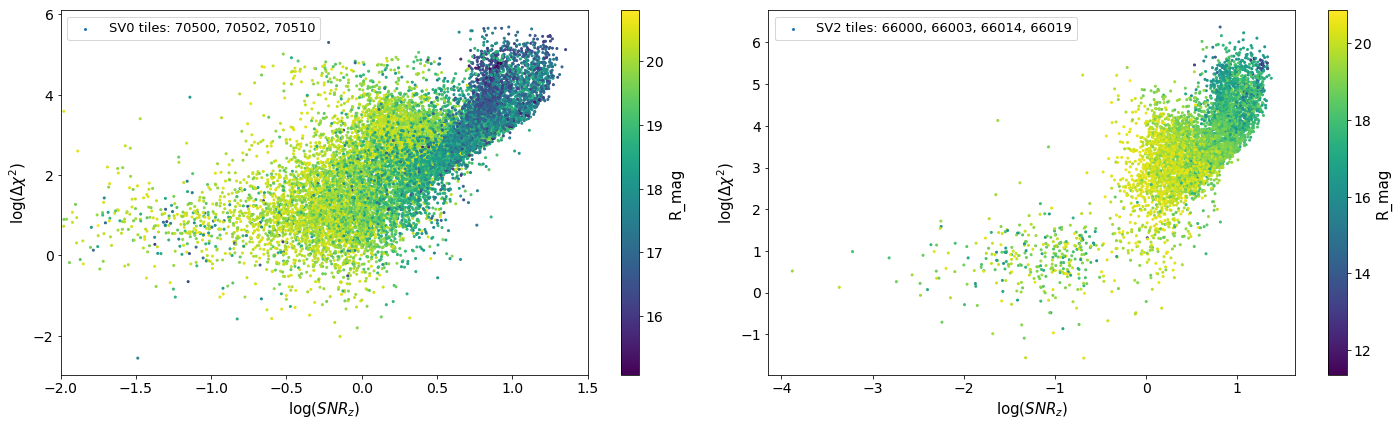

In [19]:
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.scatter(np.log10(dataSV0["snr_z"]),np.log10(dataSV0["dchi2"]),s=4,c=dataSV0["rmag"],label='SV0 tiles: 70500, 70502, 70510')
cbar=plt.colorbar()
cbar.set_label('R_mag', rotation=90)
plt.ylabel("$\log(\Delta\chi^2)$")
plt.xlabel("$\log(SNR_z)$")
plt.xlim(-2,1.5)
plt.legend()
plt.subplot(1,2,2)
plt.scatter(np.log10(dataSV2["snr_z"]),np.log10(dataSV2["dchi2"]),s=4,c=dataSV2["rmag"],label='SV2 tiles: 66000, 66003, 66014, 66019')
cbar=plt.colorbar()
cbar.set_label('R_mag', rotation=90)
plt.ylabel("$\log(\Delta\chi^2)$")
plt.xlabel("$\log(SNR_z)$")
#plt.xlim(-2,1.5)
plt.legend()
plt.tight_layout(pad=1.0)
plt.show()

In [20]:
ii=~(np.isnan(dataSV2["snr_z"]))# & (dataSV2["rmag"]>=16) & (dataSV2["rmag"]<=20)
jj=~(np.isnan(dataSV0["snr_z"]))# & (dataSV0["rmag"]>=16) & (dataSV0["rmag"]<=20)
kk=~(np.isnan(data_full["snr_z"]))# & (dataSV0["rmag"]>=16) & (dataSV0["rmag"]<=20)
dataSV0,dataSV2,data_full=dataSV0[jj],dataSV2[ii],data_full[kk]
np.log(dataSV2["snr_z"].min()), dataSV2["snr_z"].max(), dataSV2["dchi2"].min(), dataSV2["dchi2"].max()

(-9.9353, 23.613829, 0.002205207943916321, 2350845.231294117)

In [21]:
rho, pval = stats.spearmanr(dataSV0["snr_z"], dataSV0["dchi2"], nan_policy='omit')
print(r"Correlation coeficient for SNR_z and DELTACHI2 for SV0 =",rho)
print(r"p-value for SNR_z and DELTACHI2 for SV0 =", pval)

Correlation coeficient for SNR_z and DELTACHI2 for SV0 = 0.7810578030820124
p-value for SNR_z and DELTACHI2 for SV0 = 0.0


In [22]:
rho, pval = stats.spearmanr(dataSV2["snr_z"], dataSV2["dchi2"], nan_policy='omit')
print(r"Correlation coeficient for SNR_z and DELTACHI2 for SV0 =",rho)
print(r"p-value for SNR_z and DELTACHI2 for SV0 =", pval)

Correlation coeficient for SNR_z and DELTACHI2 for SV0 = 0.827977172020988
p-value for SNR_z and DELTACHI2 for SV0 = 0.0


In [23]:
rho, pval = stats.spearmanr(data_full["snr_z"], data_full["dchi2"], nan_policy='omit')
print(r"Correlation coeficient for SNR_z and DELTACHI2 for all tiles =",rho)
print(r"p-value for SNR_z and DELTACHI2 for all tiles =", pval)

Correlation coeficient for SNR_z and DELTACHI2 for all tiles = 0.8098374208551521
p-value for SNR_z and DELTACHI2 for all tiles = 0.0


In [24]:
#np.polyfit(np.log10(dataSV2['snr_z']), (dataSV2['dchi2']), 1)
import scipy
#ii=~(np.isnan(dataSV2["snr_z"]) | np.isnan(dataSV2["dchi2"]) | np.isinf(dataSV2["dchi2"]) | np.isinf(dataSV2["snr_z"]))#(dataSV2["snr_z"]!=np.isnan) & (dataSV2[dchi2]!=np.isnan)
SV2_fit=scipy.optimize.curve_fit(lambda t,a,b: a+b*t,  np.log10(dataSV2["snr_z"]),  np.log10(dataSV2["dchi2"]))
SV0_fit=scipy.optimize.curve_fit(lambda t,a,b: a+b*t,  np.log10(dataSV0["snr_z"]),  np.log10(dataSV0["dchi2"]))
all_fit=scipy.optimize.curve_fit(lambda t,a,b: a+b*t,  np.log10(data_full["snr_z"]),  np.log10(data_full["dchi2"]))
all_fit

(array([2.29378921, 1.30967969]), array([[ 3.73274178e-05, -7.82988906e-07],
        [-7.82988906e-07,  5.42146054e-05]]))

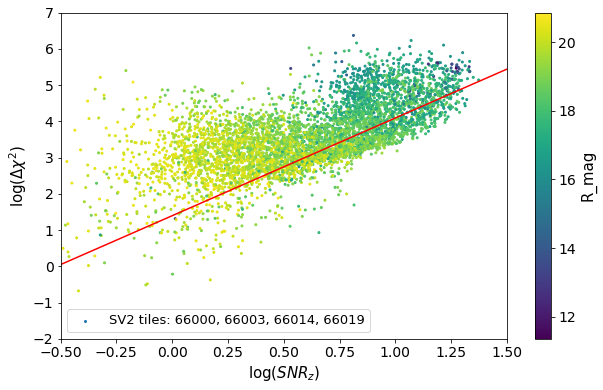

In [25]:
plt.figure(figsize=(10,6))
plt.scatter(np.log10(dataSV2["snr_z"]),np.log10(dataSV2["dchi2"]),s=4,c=dataSV2["rmag"],label='SV2 tiles: 66000, 66003, 66014, 66019')
xs=np.linspace(-2.5,1.5,100)
plt.plot(xs,SV2_fit[0][0]*xs+SV2_fit[0][1],c='r')
cbar=plt.colorbar()
cbar.set_label('R_mag', rotation=90)
plt.ylabel("$\log(\Delta\chi^2)$")
plt.xlabel("$\log(SNR_z)$")
plt.ylim(-2,7)
plt.xlim(-0.5,1.5)
plt.legend()
plt.show()

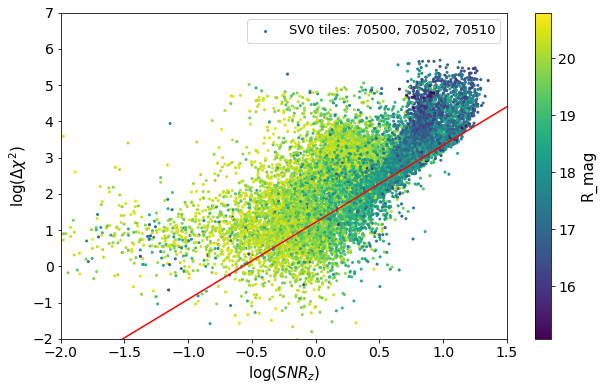

In [26]:
plt.figure(figsize=(10,6))
plt.scatter(np.log10(dataSV0["snr_z"]),np.log10(dataSV0["dchi2"]),s=4,c=dataSV0["rmag"],label='SV0 tiles: 70500, 70502, 70510')
xs=np.linspace(-2,1.5,100)
plt.plot(xs,SV0_fit[0][0]*xs+SV0_fit[0][1],c='r')
cbar=plt.colorbar()
cbar.set_label('R_mag', rotation=90)
plt.ylabel("$\log(\Delta\chi^2)$")
plt.xlabel("$\log(SNR_z)$")
plt.ylim(-2,7)
plt.xlim(-2,1.5)
plt.legend()
plt.show()

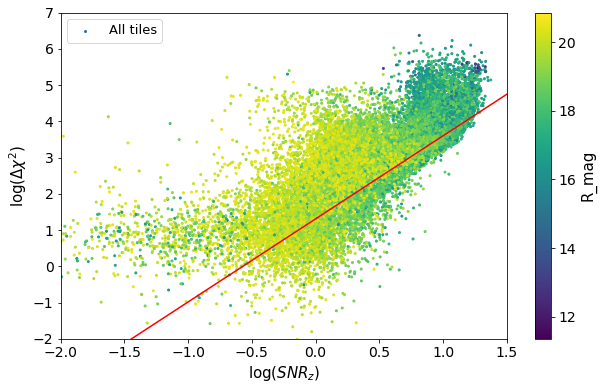

In [27]:
plt.figure(figsize=(10,6))
plt.scatter(np.log10(data_full["snr_z"]),np.log10(data_full["dchi2"]),s=4,c=data_full["rmag"],label='All tiles')
xs=np.linspace(-2,1.5,100)
plt.plot(xs,all_fit[0][0]*xs+all_fit[0][1],c='r')
cbar=plt.colorbar()
cbar.set_label('R_mag', rotation=90)
plt.ylabel("$\log(\Delta\chi^2)$")
plt.xlabel("$\log(SNR_z)$")
plt.ylim(-2,7)
plt.xlim(-2,1.5)
plt.legend()
plt.show()

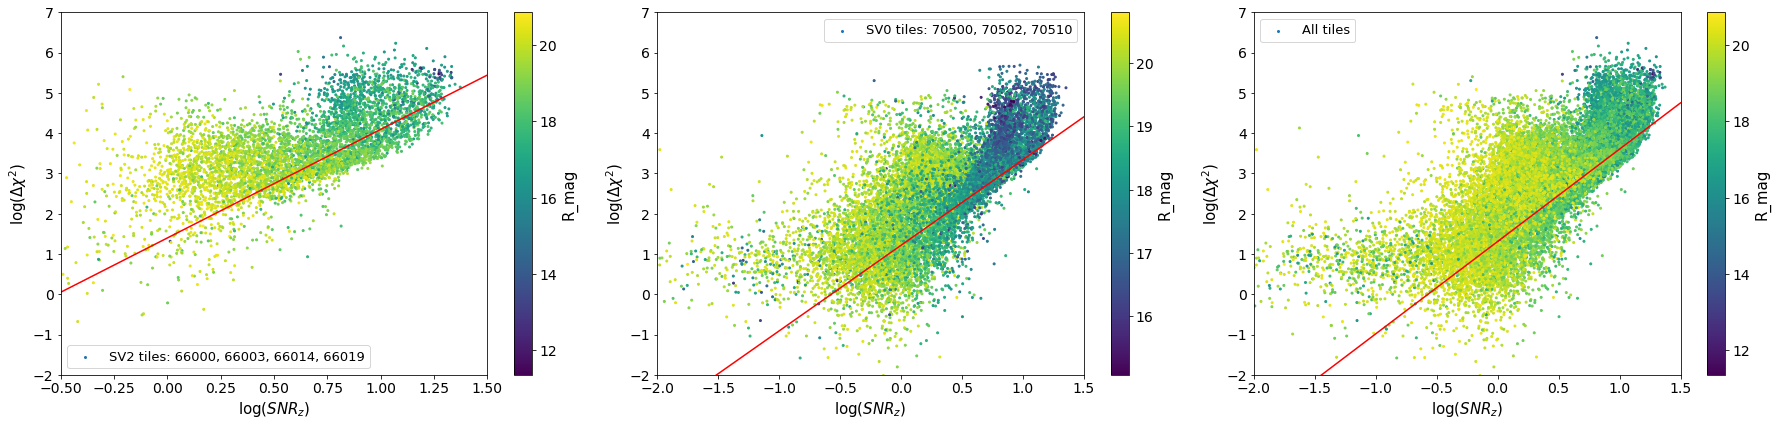

In [28]:
plt.figure(figsize=(25,6))
plt.subplot(1,3,1)
plt.scatter(np.log10(dataSV2["snr_z"]),np.log10(dataSV2["dchi2"]),s=4,c=dataSV2["rmag"],label='SV2 tiles: 66000, 66003, 66014, 66019')
xs=np.linspace(-2.5,1.5,100)
plt.plot(xs,SV2_fit[0][0]*xs+SV2_fit[0][1],c='r')
cbar=plt.colorbar()
cbar.set_label('R_mag', rotation=90)
plt.ylabel("$\log(\Delta\chi^2)$")
plt.xlabel("$\log(SNR_z)$")
plt.ylim(-2,7)
plt.xlim(-0.5,1.5)
plt.legend()
plt.subplot(1,3,2)
plt.scatter(np.log10(dataSV0["snr_z"]),np.log10(dataSV0["dchi2"]),s=4,c=dataSV0["rmag"],label='SV0 tiles: 70500, 70502, 70510')
xs=np.linspace(-2,1.5,100)
plt.plot(xs,SV0_fit[0][0]*xs+SV0_fit[0][1],c='r')
cbar=plt.colorbar()
cbar.set_label('R_mag', rotation=90)
plt.ylabel("$\log(\Delta\chi^2)$")
plt.xlabel("$\log(SNR_z)$")
plt.ylim(-2,7)
plt.xlim(-2,1.5)
plt.legend()
plt.subplot(1,3,3)
plt.scatter(np.log10(data_full["snr_z"]),np.log10(data_full["dchi2"]),s=4,c=data_full["rmag"],label='All tiles')
xs=np.linspace(-2,1.5,100)
plt.plot(xs,all_fit[0][0]*xs+all_fit[0][1],c='r')
cbar=plt.colorbar()
cbar.set_label('R_mag', rotation=90)
plt.ylabel("$\log(\Delta\chi^2)$")
plt.xlabel("$\log(SNR_z)$")
plt.ylim(-2,7)
plt.xlim(-2,1.5)
plt.legend()
plt.tight_layout(pad=1.0)

plt.show()

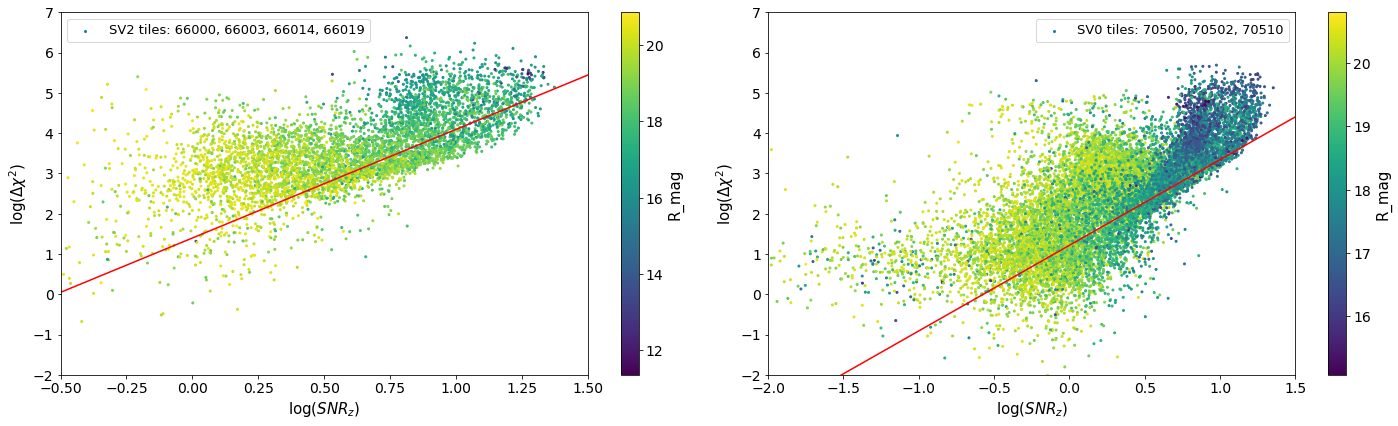

In [29]:
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.scatter(np.log10(dataSV2["snr_z"]),np.log10(dataSV2["dchi2"]),s=4,c=dataSV2["rmag"],label='SV2 tiles: 66000, 66003, 66014, 66019')
xs=np.linspace(-2.5,1.5,100)
plt.plot(xs,SV2_fit[0][0]*xs+SV2_fit[0][1],c='r')
cbar=plt.colorbar()
cbar.set_label('R_mag', rotation=90)
plt.ylabel("$\log(\Delta\chi^2)$")
plt.xlabel("$\log(SNR_z)$")
plt.ylim(-2,7)
plt.xlim(-0.5,1.5)
plt.legend()
plt.subplot(1,2,2)
plt.scatter(np.log10(dataSV0["snr_z"]),np.log10(dataSV0["dchi2"]),s=4,c=dataSV0["rmag"],label='SV0 tiles: 70500, 70502, 70510')
xs=np.linspace(-2,1.5,100)
plt.plot(xs,SV0_fit[0][0]*xs+SV0_fit[0][1],c='r')
cbar=plt.colorbar()
cbar.set_label('R_mag', rotation=90)
plt.ylabel("$\log(\Delta\chi^2)$")
plt.xlabel("$\log(SNR_z)$")
plt.ylim(-2,7)
plt.xlim(-2,1.5)
plt.legend()
plt.tight_layout(pad=1.0)

plt.show()